In [2]:
import json
import pandas as pd
import altair as alt
from langdetect import detect
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
file_paths = [
    '20231012_230826_commit_sharings.json',
    '20231012_232232_hn_sharings.json',
    '20231012_233628_pr_sharings.json',
    '20231012_234250_file_sharings.json',
    '20231012_235128_issue_sharings.json',
    '20231012_235320_discussion_sharings.json'
]

all_data = [] 

for file_path in file_paths:
    with open(file_path, 'r') as file:
        data = json.load(file)

        # first get embedded data from Sources column
        for source in data.get('Sources', []):
            source_type = source.get('Type', '')
            source_id = source.get('ID', '')
            source_url = source.get('URL', '')
            author = source.get('Author', '')
            title = source.get('Title', '')
            RepoName = source.get('RepoName', '')
            RepoLanguage = source.get('RepoLanguage', '')
            created_at = source.get('CreatedAt', '')

            # then get embedded data from ChatgptSharing column
            for chatgpt_sharing in source.get('ChatgptSharing', []):
                chatgpt_url = chatgpt_sharing.get('URL', '')
                status = chatgpt_sharing.get('Status', '')
                date_of_conversation = chatgpt_sharing.get('DateOfConversation', '')
                date_of_access = chatgpt_sharing.get('DateOfAccess', '')
                model_used = chatgpt_sharing.get('Model', '')
                num_prompts = chatgpt_sharing.get('NumberOfPrompts', 0)
                tokens_of_prompts = chatgpt_sharing.get('TokensOfPrompts', 0)
                tokens_of_answers = chatgpt_sharing.get('TokensOfAnswers', 0)

                # lastly, exract the conversation information
                for conversation in chatgpt_sharing.get('Conversations', []):
                    entry = {
                        "SourceType": source_type,
                        "SourceID": source_id,
                        "SourceURL": source_url,
                        "Author": author,
                        "Title": title,
                        "RepoName": RepoName,
                        "RepoLanguage": RepoLanguage,
                        "CreatedAt": created_at,
                        "ChatGPT_URL": chatgpt_url,
                        "Status": status,
                        "DateOfConversation": date_of_conversation,
                        "DateOfAccess": date_of_access,
                        "ModelUsed": model_used,
                        "NumPrompts": num_prompts,
                        "TokensOfPrompts": tokens_of_prompts,
                        "TokensOfAnswers": tokens_of_answers,
                        "Prompt": conversation.get("Prompt", ""),
                        "Answer": conversation.get("Answer", ""),
                        "ListOfCode": conversation.get("ListOfCode", [])
                    }
                    all_data.append(entry)

df = pd.DataFrame(all_data)

In [72]:
df.isna().sum()

SourceType               0
SourceID                 0
SourceURL                0
Author                   0
Title                    0
RepoName                 0
RepoLanguage          1666
CreatedAt                0
ChatGPT_URL              0
Status                   0
DateOfConversation       0
DateOfAccess             0
ModelUsed                0
NumPrompts               0
TokensOfPrompts          0
TokensOfAnswers          0
Prompt                   0
Answer                   0
ListOfCode               0
dtype: int64

In [68]:
# noticed duplicate prompt/answer pairs, so remove these
df = df.drop_duplicates(subset = ["Prompt", "Answer"])

Time for some EDA

In [69]:
df.head()

,SourceType,SourceID,SourceURL,Author,Title,RepoName,RepoLanguage,CreatedAt,ChatGPT_URL,Status,DateOfConversation,DateOfAccess,ModelUsed,NumPrompts,TokensOfPrompts,TokensOfAnswers,Prompt,Answer,ListOfCode
0,commit,,https://github.com/grnpin/textbox/commit/fa335...,grnpin,,grnpin/textbox,HTML,,https://chat.openai.com/share/4bad57dd-9636-4b...,200,"September 20, 2023",2023-10-12 23:53:27.348018,Default (GPT-3.5),1,330,556,このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...,ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
1,commit,,https://github.com/grnpin/textbox/commit/0dfc4...,grnpin,,grnpin/textbox,HTML,,https://chat.openai.com/share/1fd7ffc2-9264-45...,200,"September 9, 2023",2023-10-12 23:53:27.833077,Default,1,51,160,このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...,ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...,[]
2,commit,,https://github.com/grnpin/textbox/commit/811d0...,grnpin,,grnpin/textbox,HTML,,https://chat.openai.com/share/99d2d02f-7e3b-43...,200,"September 7, 2023",2023-10-12 23:53:28.345040,Default,1,916,115,refactor this code.\n\n<!DOCTYPE html>\n<html>...,ChatGPTHere's a refactored version of your HTM...,[]
3,commit,,https://github.com/bh679/MindfulAI2.0/commit/e...,bh679,,bh679/MindfulAI2.0,CSS,,https://chat.openai.com/share/90ebe55e-bd60-47...,200,"August 8, 2023",2023-10-12 23:53:29.830292,Advanced Data Analysis,6,5774,1898,server.js\n// Required libraries\nimport cors ...,ChatGPTYou've shared multiple pieces of server...,[]
4,commit,,https://github.com/bh679/MindfulAI2.0/commit/e...,bh679,,bh679/MindfulAI2.0,CSS,,https://chat.openai.com/share/90ebe55e-bd60-47...,200,"August 8, 2023",2023-10-12 23:53:29.830292,Advanced Data Analysis,6,5774,1898,"package.json\n{\n ""name"": ""mindfulai"",\n ""ve...",ChatGPTIt looks like you're having issues with...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."


In [73]:
df.tail()

,SourceType,SourceID,SourceURL,Author,Title,RepoName,RepoLanguage,CreatedAt,ChatGPT_URL,Status,DateOfConversation,DateOfAccess,ModelUsed,NumPrompts,TokensOfPrompts,TokensOfAnswers,Prompt,Answer,ListOfCode
27088,discussion,,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,ZoeLeBlanc,AI & CLI Assignment,ZoeLeBlanc/is578-intro-dh,HTML,2023-08-31T16:33:05Z,https://chat.openai.com/share/cfe2a21a-29e0-47...,200,"September 8, 2023",2023-10-12 23:53:17.501679,Default (GPT-3.5),6,156,1830,received this error code when verifying the st...,ChatGPTI apologize for the confusion. It seems...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
27089,discussion,,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,ZoeLeBlanc,AI & CLI Assignment,ZoeLeBlanc/is578-intro-dh,HTML,2023-08-31T16:33:05Z,https://chat.openai.com/share/cfe2a21a-29e0-47...,200,"September 8, 2023",2023-10-12 23:53:17.501679,Default (GPT-3.5),6,156,1830,now create a how to use the command line to cr...,ChatGPTTo create a text file with the content ...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
27090,discussion,,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,ZoeLeBlanc,AI & CLI Assignment,ZoeLeBlanc/is578-intro-dh,HTML,2023-08-31T16:33:05Z,https://chat.openai.com/share/cfe2a21a-29e0-47...,200,"September 8, 2023",2023-10-12 23:53:17.501679,Default (GPT-3.5),6,156,1830,the echo command is not working,ChatGPTI apologize for the confusion. If the e...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
27091,discussion,,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,ZoeLeBlanc,AI & CLI Assignment,ZoeLeBlanc/is578-intro-dh,HTML,2023-08-31T16:33:05Z,https://chat.openai.com/share/cfe2a21a-29e0-47...,200,"September 8, 2023",2023-10-12 23:53:17.501679,Default (GPT-3.5),6,156,1830,the echo command is still not working on windo...,ChatGPTI apologize for the inconvenience. If t...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."
27092,discussion,,https://github.com/orgs/netket/discussions/1482,MrAAafa99,Exploring the Plotting of Pair Correlation Fun...,netket/netket,Python,2023-05-25T15:11:27Z,https://chat.openai.com/share/caaa9e43-860a-46...,200,"August 16, 2023",2023-10-12 23:53:19.322053,Default (GPT-3.5),2,36,616,how do I assign error bars to the entries of a...,ChatGPTAssigning error bars to histogram entri...,"[{'ReplaceString': '[CODE_BLOCK_0]', 'Type': '..."


In [74]:
df.describe()

,Status,NumPrompts,TokensOfPrompts,TokensOfAnswers
count,18163.0,18163.000000,18163.000000,18163.000000
mean,200.0,51.151462,8015.766228,16204.392556
std,0.0,109.315835,24978.755346,28782.043523
min,200.0,1.000000,4.000000,3.000000
25%,200.0,6.000000,382.000000,1808.000000
50%,200.0,17.000000,1311.000000,5704.000000
75%,200.0,42.000000,4901.000000,15075.000000
max,200.0,574.000000,183736.000000,131131.000000


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18163 entries, 0 to 27092
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SourceType          18163 non-null  object
 1   SourceID            18163 non-null  object
 2   SourceURL           18163 non-null  object
 3   Author              18163 non-null  object
 4   Title               18163 non-null  object
 5   RepoName            18163 non-null  object
 6   RepoLanguage        16497 non-null  object
 7   CreatedAt           18163 non-null  object
 8   ChatGPT_URL         18163 non-null  object
 9   Status              18163 non-null  int64 
 10  DateOfConversation  18163 non-null  object
 11  DateOfAccess        18163 non-null  object
 12  ModelUsed           18163 non-null  object
 13  NumPrompts          18163 non-null  int64 
 14  TokensOfPrompts     18163 non-null  int64 
 15  TokensOfAnswers     18163 non-null  int64 
 16  Prompt              18163 n

Let's see how some of the data is distributed

In [11]:
df['Author'].value_counts()

Author
bennyp85        776
balo215         573
tisztamo        497
caseywschmid    456
i-a-n           289
               ... 
AshminJayson      1
caryden           1
yipkaiwing        1
pray92            1
MrAAafa99         1
Name: count, Length: 1554, dtype: int64

<Figure size 800x500 with 0 Axes>

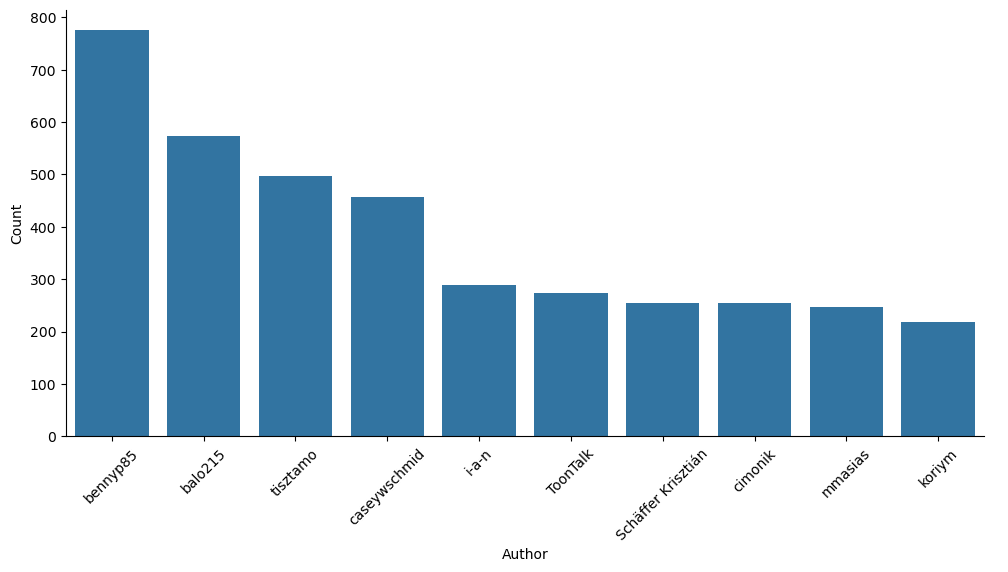

In [35]:
top_10_authors = df["Author"].value_counts().head(10).reset_index()
top_10_authors.columns = ["Author", "Count"]
plt.figure(figsize=(8, 5))
sns.catplot(x="Author", y="Count", kind="bar", data=top_10_authors, height=5, aspect=2)
plt.xticks(rotation=45)
plt.show()

In [79]:
df['RepoName'].value_counts().sort_index()

RepoName
                                        954
0x79de/0x79de.github.io                   1
10-Kirito/Notes                           5
152334H/152334H.github.io                 1
1766left/EasyFill                         9
                                       ... 
zmaril/multirender                       10
zsviczian/obsidian-excalidraw-plugin      3
zudsniper/learn_from_cgpt                12
zumatt/personalWebsite                    7
zyhzsh/S7-Doc                            28
Name: count, Length: 1480, dtype: int64

In [81]:
df['RepoLanguage'].value_counts()

RepoLanguage
CSS         4162
HTML        1953
Python      1908
C#          1051
C++          981
            ... 
APL            1
Mustache       1
MDX            1
Groovy         1
Nim            1
Name: count, Length: 72, dtype: int64

In [82]:
df['RepoLanguage'].unique()

array(['HTML', 'CSS', 'JavaScript', 'Python', 'Batchfile', None, 'Lua',
       'Jinja', 'Shell', 'Java', 'C', 'Dockerfile', 'C#', 'Pascal', 'Go',
       'EJS', 'GAML', 'Cython', '', 'TypeScript', 'Jupyter Notebook',
       'Vue', 'PHP', 'Kotlin', 'C++', 'Solidity', 'Emacs Lisp', 'F#',
       'Dart', 'MDX', 'PowerShell', 'Assembly', 'ASL', 'APL',
       'API Blueprint', 'ANTLR', 'CodeQL', 'R', 'Astro', 'Rust', 'PLSQL',
       'PLpgSQL', 'Haskell', 'GLSL', 'MATLAB', 'Procfile', 'Makefile',
       'HCL', 'Awk', 'ShaderLab', 'AutoHotkey', 'Julia', 'Apex', 'TeX',
       'Qt Script', 'Swift', 'Asymptote', 'Clojure', 'Mustache', 'NASL',
       'Coq', 'Nix', 'Nunjucks', 'AppleScript', 'Ruby', 'Verilog', 'Perl',
       'Game Maker Language', 'Zig', 'Objective-C', 'Groovy', 'Nim',
       'SystemVerilog'], dtype=object)

<Figure size 800x500 with 0 Axes>

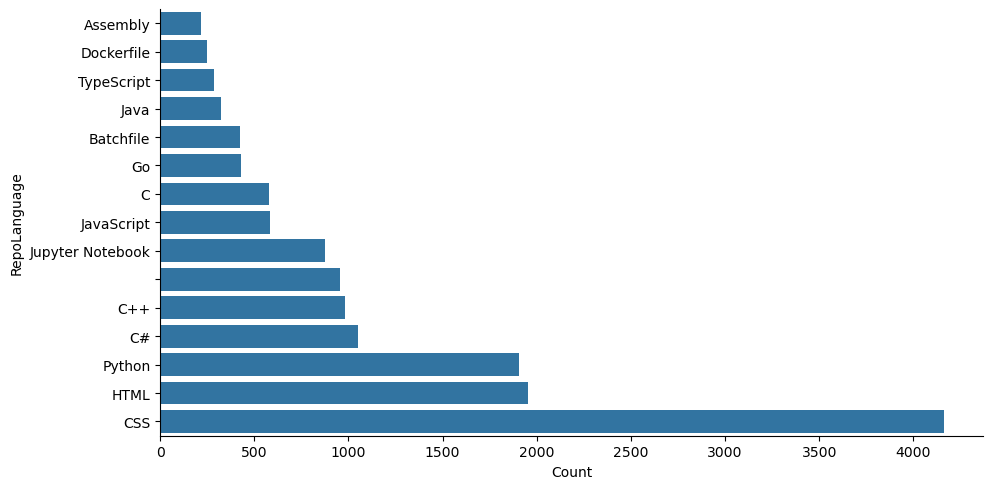

In [88]:
top_15_languages = df["RepoLanguage"].value_counts().head(15).reset_index()
top_15_languages.columns = ["RepoLanguage", "Count"]
top_15_languages = top_15_languages.sort_values(by='Count', ascending=True)
plt.figure(figsize=(8, 5))
sns.catplot(x="Count", y="RepoLanguage", kind="bar", data=top_15_languages, height=5, aspect=2)
# plt.xticks(rotation=45)
plt.show()

In [95]:
df['NumPrompts'].value_counts().sort_index()

NumPrompts
1      1416
2       622
3       684
4       701
5       655
       ... 
117     116
167     166
290     289
302     301
574     573
Name: count, Length: 78, dtype: int64

In [13]:
df['ModelUsed'].value_counts()

ModelUsed
Default (GPT-3.5)         6888
GPT-4                     6526
Advanced Data Analysis    2041
Plugins                   2010
Default                    466
Web Browsing               221
Model: Default              11
Name: count, dtype: int64

The prompt counts and model usage seems interesting, let's plot these to see the actual distributions

In [14]:
# don't make the same mistake of using the entire dataset and subset it first
df_prompts = df[['NumPrompts']]

alt.data_transformers.disable_max_rows()

alt.Chart(df_prompts).mark_bar().encode(
    x = alt.X('NumPrompts', bin = alt.Bin(maxbins = 20), title = 'Number of Prompts'),
    y = alt.Y('count()', title = 'Count')
)

alt.Chart(...)

Most converstaions are limited to 100 prompts at most, but there are some interesting outliers that may be worth diving into more.

In [15]:
df_model = df[['ModelUsed']]

alt.Chart(df_model).mark_bar().encode(
    x = alt.X('count()', title = 'Count'),
    y = alt.Y('ModelUsed:N', title = 'Model', sort = 'x')
)

alt.Chart(...)

I wonder if there's a relationship between the number of prompts and the model used? This might be difficult to figure out since there are clearly two dominant models, but it might be worth exploring. Additionally, it might be worth figuring out if the higher tier models are actually better and compare the answer to prompts depending on the model. Building on this further, we can evaluate the 'quality' of responses depending on the model.

##### Research Question: How do GPT answers vary based on the model used? Is there specific language or vocabulary that differs between each model? Do the answer lengths differ?

Let's subset the data to only focus on the model, prompts, and answers

In [16]:
df_rq1 = df[['ModelUsed', 'Prompt', 'Answer']]

df_rq1.head()

,ModelUsed,Prompt,Answer
0,Default (GPT-3.5),このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...,ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...
1,Default,このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...,ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...
2,Default,refactor this code.\n\n<!DOCTYPE html>\n<html>...,ChatGPTHere's a refactored version of your HTM...
3,Advanced Data Analysis,server.js\n// Required libraries\nimport cors ...,ChatGPTYou've shared multiple pieces of server...
4,Advanced Data Analysis,"package.json\n{\n ""name"": ""mindfulai"",\n ""ve...",ChatGPTIt looks like you're having issues with...


First, let's combine all the default models into one category

In [17]:
df_rq1.loc[:, 'ModelUsed'] = df_rq1['ModelUsed'].replace(
    ['Model: Default', 'Default'], 'Default (GPT-3.5)'
)

df_rq1.head()

,ModelUsed,Prompt,Answer
0,Default (GPT-3.5),このコードだと、スマートフォンでキーボードを表示したときにbuttonがキーボードの下に隠れ...,ChatGPTキーボードが表示されたときにボタンをキーボードの上に移動させるには、CSSでキ...
1,Default (GPT-3.5),このコードなんですが、Placeholder上でちゃんと改行するコードにできますか。\n\n...,ChatGPTはい、改行を含むPlaceholder文字列を設定するコードを作成することがで...
2,Default (GPT-3.5),refactor this code.\n\n<!DOCTYPE html>\n<html>...,ChatGPTHere's a refactored version of your HTM...
3,Advanced Data Analysis,server.js\n// Required libraries\nimport cors ...,ChatGPTYou've shared multiple pieces of server...
4,Advanced Data Analysis,"package.json\n{\n ""name"": ""mindfulai"",\n ""ve...",ChatGPTIt looks like you're having issues with...


For interpretability, we will also remove non-english prompts/answers. Additionally, we will remove 'ChatGPT' at the start of each answer as this will skew results if we care about word counts/frequencies.

In [18]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# filter on prompt and answer columns, also remove ChatGPT from the start of Answer
df_rq1_filtered = df_rq1[df_rq1['Prompt'].apply(is_english) & df_rq1['Answer'].apply(is_english)]
df_rq1_filtered.loc[:, 'Answer'] = df_rq1_filtered['Answer'].str.replace(r'^ChatGPT', '', regex  = True)

df_rq1_filtered.head()

,ModelUsed,Prompt,Answer
2,Default (GPT-3.5),refactor this code.\n\n<!DOCTYPE html>\n<html>...,Here's a refactored version of your HTML and J...
3,Advanced Data Analysis,server.js\n// Required libraries\nimport cors ...,You've shared multiple pieces of server code t...
4,Advanced Data Analysis,"package.json\n{\n ""name"": ""mindfulai"",\n ""ve...",It looks like you're having issues with your s...
5,Advanced Data Analysis,\n/home/bitnami/.pm2/logs/Mindful-AI-out-0.log...,"From the logs and the code you provided, there..."
6,Advanced Data Analysis,\n/home/bitnami/.pm2/logs/Mindful-AI-out-0.log...,The logs indicate two main issues:The module P...


In [36]:
df_rq1_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14307 entries, 2 to 27092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ModelUsed  14307 non-null  object
 1   Prompt     14307 non-null  object
 2   Answer     14307 non-null  object
dtypes: object(3)
memory usage: 447.1+ KB


Let's take a high-level look at models and answers provided, specifically on the average word counts by model. To do this, we will need to perform some extra cleaning, removing punctuation from the text.

In [37]:
def clean_answer(answer):

    # keep contractions good
    answer = re.sub(r"(?<=\w)'(?=\w)", "", answer)
    # take out punctuation, add space
    answer = re.sub(r"[.,;!?:]", " ", answer)
    # deal with any additional symbols, characters, etc.
    answer = re.sub(r"[^\w\s]", "", answer)
    answer = answer.lower()

    return answer

df_rq1_filtered.loc[:, 'Answer'] = df_rq1_filtered['Answer'].apply(clean_answer)

df_rq1_filtered.head()

,ModelUsed,Prompt,Answer
2,Default (GPT-3.5),refactor this code.\n\n<!DOCTYPE html>\n<html>...,heres a refactored version of your html and ja...
3,Advanced Data Analysis,server.js\n// Required libraries\nimport cors ...,youve shared multiple pieces of server code th...
4,Advanced Data Analysis,"package.json\n{\n ""name"": ""mindfulai"",\n ""ve...",it looks like youre having issues with your se...
5,Advanced Data Analysis,\n/home/bitnami/.pm2/logs/Mindful-AI-out-0.log...,from the logs and the code you provided there...
6,Advanced Data Analysis,\n/home/bitnami/.pm2/logs/Mindful-AI-out-0.log...,the logs indicate two main issues the module p...


Now that the answer column should be mostly clean, we can start doing some analysis. Let's start with word counts, a simple metric to calculate.

In [38]:
df_rq1_clean = df_rq1_filtered.copy()
df_rq1_clean.loc[:, 'WordCount'] = df_rq1_clean['Answer'].apply(lambda x: len(x.split()))

df_rq1_clean.head()

,ModelUsed,Prompt,Answer,WordCount
2,Default (GPT-3.5),refactor this code.\n\n<!DOCTYPE html>\n<html>...,heres a refactored version of your html and ja...,85
3,Advanced Data Analysis,server.js\n// Required libraries\nimport cors ...,youve shared multiple pieces of server code th...,514
4,Advanced Data Analysis,"package.json\n{\n ""name"": ""mindfulai"",\n ""ve...",it looks like youre having issues with your se...,343
5,Advanced Data Analysis,\n/home/bitnami/.pm2/logs/Mindful-AI-out-0.log...,from the logs and the code you provided there...,266
6,Advanced Data Analysis,\n/home/bitnami/.pm2/logs/Mindful-AI-out-0.log...,the logs indicate two main issues the module p...,260


In [39]:
summary_stats = df_rq1_clean.groupby('ModelUsed')['WordCount'].agg(
    mean = 'mean',
    median = 'median',
    min = 'min',
    max = 'max',
    std = 'std',
    count = 'count'
).reset_index()

summary_stats

,ModelUsed,mean,median,min,max,std,count
0,Advanced Data Analysis,200.584893,164.0,1,1785,163.091860,1549
1,Default (GPT-3.5),166.289205,133.0,1,2478,136.044052,5688
2,GPT-4,161.966114,140.0,1,785,121.556977,5371
3,Plugins,176.831593,154.0,1,1290,122.242600,1532
4,Web Browsing,224.562874,182.0,23,1039,169.818704,167


We can see that GPT-4 responses have a lot less variance and overall, have a lower word count. The default model, 3.5, has a large range of values, but web browsing and advanced data anlysis, on average, have larger word counts for responses.

C:\Users\PC\AppData\Local\Temp\ipykernel_10404\1000061320.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rq1_clean, x='ModelUsed', y='WordCount', palette='Set2')


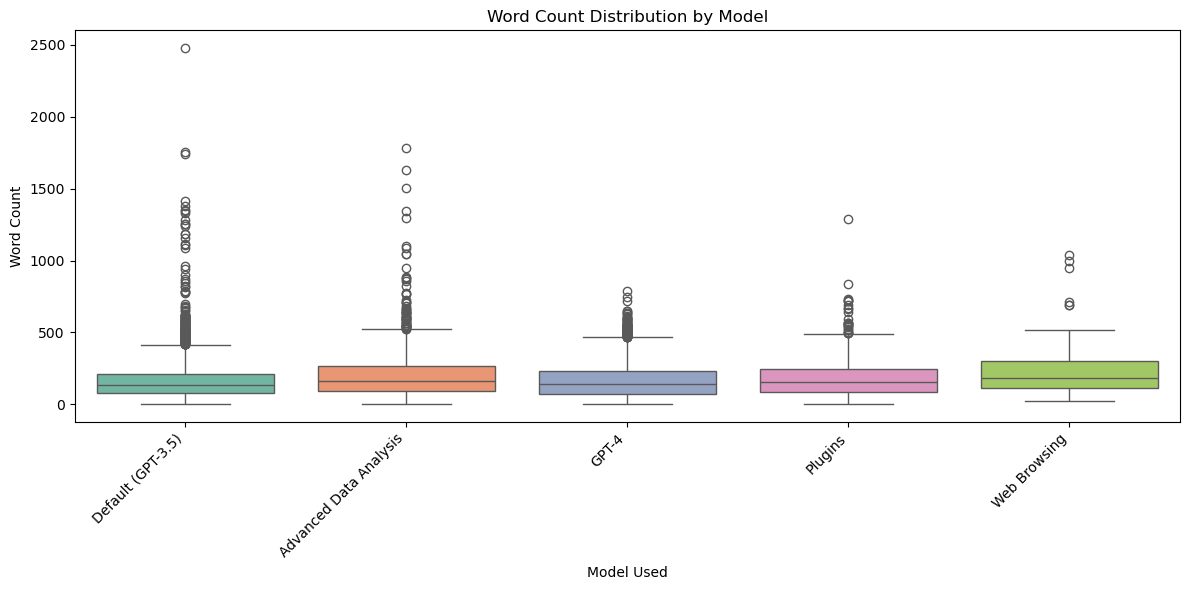

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_rq1_clean, x='ModelUsed', y='WordCount', palette='Set2')

# Add labels and title
plt.xlabel('Model Used')
plt.ylabel('Word Count')
plt.title('Word Count Distribution by Model')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

### What types of issues (bugs, feature requests, theoretical questions, etc.) do developers most commonly present to ChatGPT?

#### Firstly, decide the keywords of different types of issues

In [42]:
keyword_categories = {
    "Bug Reports": ["error", "bug", "crash", "exception", "fail", "issue", "fix"],
    "Feature Requests": ["feature", "enhance", "add support", "improve", "implement"],
    "Theoretical Questions": ["explain", "theory", "why", "difference", "how does"],
    "Performance Issues": ["slow", "optimize", "bottleneck", "latency", "performance"],
    "Code Help": ["how to", "example", "sample", "syntax", "help", "debug"]
}

#### Secondly, clean Prompt

In [48]:
def clean_prompt(prompt):

    # keep contractions good
    answer = re.sub(r"(?<=\w)'(?=\w)", "", prompt)
    # take out punctuation, add space
    answer = re.sub(r"[.,;!?:]", " ", prompt)
    # deal with any additional symbols, characters, etc.
    answer = re.sub(r"[^\w\s]", "", prompt)
    answer = answer.lower()

    return answer

df_rq1_clean_new = df_rq1_clean.copy()
df_rq1_clean_new.loc[:, 'Prompt'] = df_rq1_clean_new['Prompt'].apply(clean_answer)

df_rq1_clean_new.head()

,ModelUsed,Prompt,Answer,WordCount
2,Default (GPT-3.5),refactor this code \n\n doctype html\nhtml\n ...,heres a refactored version of your html and ja...,85
3,Advanced Data Analysis,server js\n required libraries\nimport cors fr...,youve shared multiple pieces of server code th...,514
4,Advanced Data Analysis,package json\n\n name mindfulai \n version ...,it looks like youre having issues with your se...,343
5,Advanced Data Analysis,\nhomebitnami pm2logsmindfulaiout0 log last 15...,from the logs and the code you provided there...,266
6,Advanced Data Analysis,\nhomebitnami pm2logsmindfulaiout0 log last 15...,the logs indicate two main issues the module p...,260


In [59]:
def count_keywords(text, category_keywords):
    text = text.lower() if isinstance(text, str) else ""
    return sum(text.count(keyword) for keyword in category_keywords)

category_counts = {category: 0 for category in keyword_categories}
for category, keywords in keyword_categories.items():
    category_counts[category] += df["Prompt"].apply(lambda x: count_keywords(x, keywords)).sum()
    category_counts[category] += df["Answer"].apply(lambda x: count_keywords(x, keywords)).sum()


In [61]:
category_df = pd.DataFrame(category_counts.items(), columns=["Issue Type", "Count"])
category_df.sort_values('Count')
category_df

,Issue Type,Count
0,Bug Reports,22203
1,Feature Requests,12170
2,Theoretical Questions,3478
3,Performance Issues,2652
4,Code Help,19659


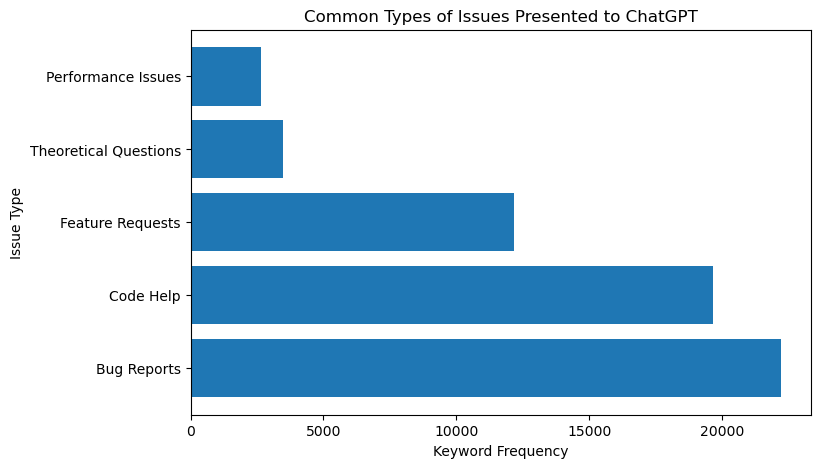

In [63]:
category_df = pd.DataFrame(category_counts.items(), columns=["Issue Type", "Count"])
category_df = category_df.sort_values('Count')

plt.figure(figsize=(8, 5))
    
plt.barh(category_df["Issue Type"], category_df["Count"])
plt.xlabel("Keyword Frequency")
plt.ylabel("Issue Type")
plt.title("Common Types of Issues Presented to ChatGPT")
plt.gca().invert_yaxis()
plt.show()

### How many turns does it take on average to reach a conclusion? ### What is the typical structure of conversations between developers and ChatGPT? 

In [133]:
mean_turns = df["NumPrompts"].mean()
median_turns = df["NumPrompts"].median()
mode_turns = df["NumPrompts"].mode()[0]

print(f"Mean NumPrompts: {mean_turns:.2f}")
print(f"Median NumPrompts: {median_turns}")
print(f"Most common NumPrompts (Mode): {mode_turns}")


Mean NumPrompts: 51.15
Median NumPrompts: 17.0
Most common NumPrompts (Mode): 1


The mean number of prompts per conversation is 51.15, which suggests that interactions tend to be long and multi-turn.

C:\Users\PC\AppData\Local\Temp\ipykernel_10404\2602114733.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="NumPrompts", y="Count", data=top_NumPrompts, palette="Blues_r")


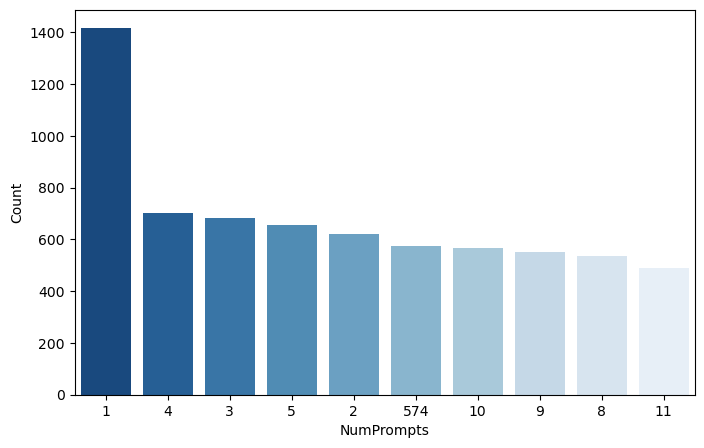

In [134]:
top_NumPrompts = df["NumPrompts"].value_counts().head(10).reset_index()
top_NumPrompts.columns = ["NumPrompts", "Count"]
top_NumPrompts["NumPrompts"] = top_NumPrompts["NumPrompts"].astype(str) 
top_NumPrompts = top_NumPrompts.sort_values(by="Count", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="NumPrompts", y="Count", data=top_NumPrompts, palette="Blues_r")
plt.show()

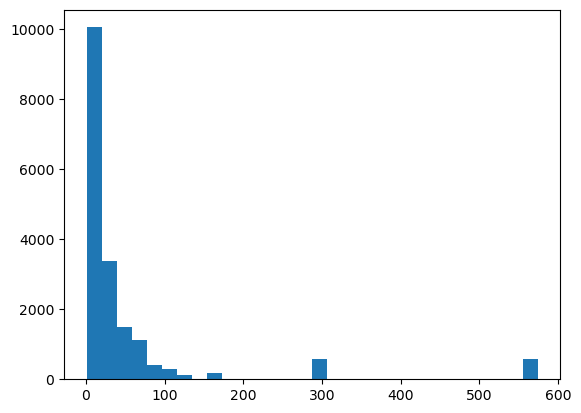

In [100]:
# df['NumPrompts'].hist(bins=20)
plt.hist(df['NumPrompts'], bins=30)
plt.show()